**Setup Library**

In [1]:
from PIL import Image
import numpy as np
import cv2
import torch
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

**Setup and divide train/val/test**

In [2]:
data = pd.read_csv('/content/final.csv')
df = pd.DataFrame()
df['image_path'] = data['image']
df['mask_path'] = data['mask']

In [3]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df,test_size = 0.2, random_state = 28)
df_val, df_test = train_test_split(df_val,test_size = 0.5, random_state = 28)

In [4]:
df_train1 = np.array(df_train['image_path'])
df_train2 = np.array(df_train['mask_path'])
df_val1 = np.array(df_val['image_path'])
df_val2 = np.array(df_val['mask_path'])
df_test1 = np.array(df_test['image_path'])
df_test2 = np.array(df_test['mask_path'])

In [5]:
import torch
import numpy as np
from torch.utils.data import DataLoader

transform = transforms.Compose([
                  transforms.Resize((224,224)),
                  transforms.ToTensor(),

])

class dataset():
  def __init__(self, image_path , mask_path, transform = None):
    self.image_path = image_path
    self.mask_path = mask_path
    self.transform = transform
  def __len__(self):
    return len(self.image_path)
  def __getitem__(self,idx):
    image = self.image_path[idx]
    mask = self.mask_path[idx]
    image = Image.open(image)
    mask = Image.open(mask)
    mask = mask.convert('L')
    image = self.transform(image)
    mask = self.transform(mask)
    mask[mask>=0.1] = 1
    mask[mask<0.1] = 0
    return image,mask
train = dataset(image_path = df_train1 , mask_path = df_train2, transform = transform)
val = dataset(image_path = df_val1 , mask_path = df_val2, transform = transform)
test = dataset(image_path = df_test1 , mask_path = df_test2, transform = transform)
train_loader = DataLoader(dataset = train , batch_size = 4)
val_loader = DataLoader(dataset = val , batch_size = 4)
test_loader = DataLoader(dataset = test , batch_size = 1)


**Loss function and Evaluate Matric**

In [6]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

**Setup GPU**

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

**Unet model**

In [30]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)
    
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)        
        self.up3 = Up(256, 128//factor, bilinear)        
        self.up4 = Up(128, 64, bilinear)        
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
model = UNet(3, 1).to(device)
out = model(torch.randn(1, 3, 256, 256).to(device))
print(out.shape)

torch.Size([1, 1, 256, 256])


**Train Function**

In [32]:
from tqdm import tqdm
def compute_iou(model, loader, threshold=0.5):
    valloss = []
    with torch.no_grad():
        for step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            loss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss.append(loss)
    return np.array(valloss).mean()
def train_model(train_loader, val_loader, loss_func, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    path = []
    max = 0
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i, (image, mask) in enumerate(tqdm(train_loader)):
            image = image.to(device)
            mask = mask.to(device)
            outputs = model(image)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            
            
            train_dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            loss = loss_func(outputs, mask)
            losses.append(loss.item())
            train_iou.append(train_dice)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        val_mean_iou = compute_iou(model, val_loader)
        #scheduler.step(val_mean_iou)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        if val_mean_iou > max:
          max = val_mean_iou
          torch.save(model.state_dict(), 'Unet-%d.pth' % (epoch+1))
          path.append('Unet-%d.pth' % (epoch+1))
          print('[Saving Snapshot:]', 'Unet-%d.pth'% (epoch+1))
        print('Epoch : {}/{}'.format(epoch+1, num_epochs))
        print('loss: {:.3f} - dice_coef: {:.3f} - val_dice_coef: {:.3f}'.format(np.array(losses).mean(),
                                                                               np.array(train_iou).mean(),
                                                                               val_mean_iou))
    return loss_history, train_history, val_history, path

**Train Process**

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
loss_history, train_history, val_history, path = train_model(train_loader, val_loader, bce_dice_loss, optimizer, num_epochs)

100%|██████████| 29/29 [00:02<00:00, 10.44it/s]


[Saving Snapshot:] Unet-1.pth
Epoch : 1/100
loss: 0.481 - dice_coef: 0.896 - val_dice_coef: 0.896


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


[Saving Snapshot:] Unet-2.pth
Epoch : 2/100
loss: 0.277 - dice_coef: 0.945 - val_dice_coef: 0.957


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 3/100
loss: 0.220 - dice_coef: 0.955 - val_dice_coef: 0.941


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


[Saving Snapshot:] Unet-4.pth
Epoch : 4/100
loss: 0.246 - dice_coef: 0.948 - val_dice_coef: 0.964


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


[Saving Snapshot:] Unet-5.pth
Epoch : 5/100
loss: 0.161 - dice_coef: 0.968 - val_dice_coef: 0.970


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 6/100
loss: 0.128 - dice_coef: 0.974 - val_dice_coef: 0.967


100%|██████████| 29/29 [00:02<00:00, 10.61it/s]


Epoch : 7/100
loss: 0.112 - dice_coef: 0.977 - val_dice_coef: 0.964


100%|██████████| 29/29 [00:02<00:00, 10.62it/s]


Epoch : 8/100
loss: 0.105 - dice_coef: 0.978 - val_dice_coef: 0.951


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 9/100
loss: 0.111 - dice_coef: 0.977 - val_dice_coef: 0.966


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


[Saving Snapshot:] Unet-10.pth
Epoch : 10/100
loss: 0.097 - dice_coef: 0.979 - val_dice_coef: 0.971


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


[Saving Snapshot:] Unet-11.pth
Epoch : 11/100
loss: 0.086 - dice_coef: 0.981 - val_dice_coef: 0.971


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


[Saving Snapshot:] Unet-12.pth
Epoch : 12/100
loss: 0.081 - dice_coef: 0.981 - val_dice_coef: 0.971


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


[Saving Snapshot:] Unet-13.pth
Epoch : 13/100
loss: 0.076 - dice_coef: 0.982 - val_dice_coef: 0.973


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 14/100
loss: 0.069 - dice_coef: 0.984 - val_dice_coef: 0.973


100%|██████████| 29/29 [00:02<00:00, 10.50it/s]


Epoch : 15/100
loss: 0.068 - dice_coef: 0.984 - val_dice_coef: 0.973


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


[Saving Snapshot:] Unet-16.pth
Epoch : 16/100
loss: 0.066 - dice_coef: 0.985 - val_dice_coef: 0.975


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


[Saving Snapshot:] Unet-17.pth
Epoch : 17/100
loss: 0.064 - dice_coef: 0.985 - val_dice_coef: 0.976


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 18/100
loss: 0.059 - dice_coef: 0.986 - val_dice_coef: 0.975


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 19/100
loss: 0.059 - dice_coef: 0.986 - val_dice_coef: 0.969


100%|██████████| 29/29 [00:02<00:00, 10.58it/s]


[Saving Snapshot:] Unet-20.pth
Epoch : 20/100
loss: 0.061 - dice_coef: 0.985 - val_dice_coef: 0.978


100%|██████████| 29/29 [00:02<00:00, 10.51it/s]


[Saving Snapshot:] Unet-21.pth
Epoch : 21/100
loss: 0.054 - dice_coef: 0.987 - val_dice_coef: 0.978


100%|██████████| 29/29 [00:02<00:00, 10.51it/s]


Epoch : 22/100
loss: 0.053 - dice_coef: 0.987 - val_dice_coef: 0.977


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


[Saving Snapshot:] Unet-23.pth
Epoch : 23/100
loss: 0.053 - dice_coef: 0.987 - val_dice_coef: 0.978


100%|██████████| 29/29 [00:02<00:00, 10.48it/s]


Epoch : 24/100
loss: 0.055 - dice_coef: 0.987 - val_dice_coef: 0.978


100%|██████████| 29/29 [00:02<00:00, 10.58it/s]


[Saving Snapshot:] Unet-25.pth
Epoch : 25/100
loss: 0.053 - dice_coef: 0.987 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


[Saving Snapshot:] Unet-26.pth
Epoch : 26/100
loss: 0.053 - dice_coef: 0.987 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


[Saving Snapshot:] Unet-27.pth
Epoch : 27/100
loss: 0.051 - dice_coef: 0.987 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.52it/s]


Epoch : 28/100
loss: 0.052 - dice_coef: 0.987 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


[Saving Snapshot:] Unet-29.pth
Epoch : 29/100
loss: 0.049 - dice_coef: 0.988 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Epoch : 30/100
loss: 0.045 - dice_coef: 0.989 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.52it/s]


Epoch : 31/100
loss: 0.046 - dice_coef: 0.989 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00,  9.99it/s]


[Saving Snapshot:] Unet-32.pth
Epoch : 32/100
loss: 0.049 - dice_coef: 0.988 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


[Saving Snapshot:] Unet-33.pth
Epoch : 33/100
loss: 0.045 - dice_coef: 0.989 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 34/100
loss: 0.044 - dice_coef: 0.989 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 35/100
loss: 0.040 - dice_coef: 0.990 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 36/100
loss: 0.045 - dice_coef: 0.989 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


[Saving Snapshot:] Unet-37.pth
Epoch : 37/100
loss: 0.042 - dice_coef: 0.990 - val_dice_coef: 0.985


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 38/100
loss: 0.040 - dice_coef: 0.990 - val_dice_coef: 0.984


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Epoch : 39/100
loss: 0.043 - dice_coef: 0.989 - val_dice_coef: 0.977


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 40/100
loss: 0.046 - dice_coef: 0.989 - val_dice_coef: 0.977


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 41/100
loss: 0.045 - dice_coef: 0.989 - val_dice_coef: 0.979


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 42/100
loss: 0.045 - dice_coef: 0.989 - val_dice_coef: 0.984


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 43/100
loss: 0.038 - dice_coef: 0.990 - val_dice_coef: 0.984


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 44/100
loss: 0.037 - dice_coef: 0.991 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 45/100
loss: 0.038 - dice_coef: 0.990 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 46/100
loss: 0.039 - dice_coef: 0.990 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 47/100
loss: 0.040 - dice_coef: 0.990 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


[Saving Snapshot:] Unet-48.pth
Epoch : 48/100
loss: 0.037 - dice_coef: 0.991 - val_dice_coef: 0.987


100%|██████████| 29/29 [00:02<00:00, 10.51it/s]


Epoch : 49/100
loss: 0.035 - dice_coef: 0.991 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 50/100
loss: 0.037 - dice_coef: 0.991 - val_dice_coef: 0.981


100%|██████████| 29/29 [00:02<00:00, 10.52it/s]


Epoch : 51/100
loss: 0.039 - dice_coef: 0.990 - val_dice_coef: 0.984


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 52/100
loss: 0.044 - dice_coef: 0.990 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.58it/s]


Epoch : 53/100
loss: 0.042 - dice_coef: 0.990 - val_dice_coef: 0.985


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Epoch : 54/100
loss: 0.037 - dice_coef: 0.991 - val_dice_coef: 0.981


100%|██████████| 29/29 [00:02<00:00, 10.52it/s]


Epoch : 55/100
loss: 0.042 - dice_coef: 0.990 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 56/100
loss: 0.038 - dice_coef: 0.991 - val_dice_coef: 0.986


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 57/100
loss: 0.034 - dice_coef: 0.991 - val_dice_coef: 0.985


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 58/100
loss: 0.036 - dice_coef: 0.991 - val_dice_coef: 0.986


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 59/100
loss: 0.032 - dice_coef: 0.992 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 60/100
loss: 0.036 - dice_coef: 0.991 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 61/100
loss: 0.037 - dice_coef: 0.991 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.59it/s]


Epoch : 62/100
loss: 0.040 - dice_coef: 0.990 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 63/100
loss: 0.033 - dice_coef: 0.992 - val_dice_coef: 0.984


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 64/100
loss: 0.034 - dice_coef: 0.992 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 65/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Epoch : 66/100
loss: 0.030 - dice_coef: 0.993 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 67/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.979


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 68/100
loss: 0.034 - dice_coef: 0.991 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.51it/s]


Epoch : 69/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 70/100
loss: 0.030 - dice_coef: 0.992 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Epoch : 71/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.985


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 72/100
loss: 0.035 - dice_coef: 0.991 - val_dice_coef: 0.986


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 73/100
loss: 0.037 - dice_coef: 0.991 - val_dice_coef: 0.985


100%|██████████| 29/29 [00:02<00:00, 10.52it/s]


Epoch : 74/100
loss: 0.034 - dice_coef: 0.991 - val_dice_coef: 0.984


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Epoch : 75/100
loss: 0.032 - dice_coef: 0.992 - val_dice_coef: 0.987


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 76/100
loss: 0.030 - dice_coef: 0.992 - val_dice_coef: 0.985


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Epoch : 77/100
loss: 0.030 - dice_coef: 0.992 - val_dice_coef: 0.986


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 78/100
loss: 0.033 - dice_coef: 0.992 - val_dice_coef: 0.985


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 79/100
loss: 0.033 - dice_coef: 0.992 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 80/100
loss: 0.035 - dice_coef: 0.991 - val_dice_coef: 0.981


100%|██████████| 29/29 [00:02<00:00, 10.50it/s]


Epoch : 81/100
loss: 0.034 - dice_coef: 0.991 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 82/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.981


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 83/100
loss: 0.030 - dice_coef: 0.992 - val_dice_coef: 0.979


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 84/100
loss: 0.029 - dice_coef: 0.992 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 85/100
loss: 0.028 - dice_coef: 0.993 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 86/100
loss: 0.027 - dice_coef: 0.993 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 87/100
loss: 0.028 - dice_coef: 0.993 - val_dice_coef: 0.983


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 88/100
loss: 0.029 - dice_coef: 0.993 - val_dice_coef: 0.984


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 89/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.985


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 90/100
loss: 0.029 - dice_coef: 0.993 - val_dice_coef: 0.979


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Epoch : 91/100
loss: 0.032 - dice_coef: 0.992 - val_dice_coef: 0.982


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 92/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.975


100%|██████████| 29/29 [00:02<00:00, 10.55it/s]


Epoch : 93/100
loss: 0.033 - dice_coef: 0.992 - val_dice_coef: 0.977


100%|██████████| 29/29 [00:02<00:00, 10.56it/s]


Epoch : 94/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.52it/s]


Epoch : 95/100
loss: 0.026 - dice_coef: 0.993 - val_dice_coef: 0.981


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 96/100
loss: 0.027 - dice_coef: 0.993 - val_dice_coef: 0.980


100%|██████████| 29/29 [00:02<00:00, 10.52it/s]


Epoch : 97/100
loss: 0.027 - dice_coef: 0.993 - val_dice_coef: 0.981


100%|██████████| 29/29 [00:02<00:00, 10.52it/s]


Epoch : 98/100
loss: 0.026 - dice_coef: 0.993 - val_dice_coef: 0.981


100%|██████████| 29/29 [00:02<00:00, 10.57it/s]


Epoch : 99/100
loss: 0.030 - dice_coef: 0.992 - val_dice_coef: 0.979


100%|██████████| 29/29 [00:02<00:00, 10.53it/s]


Epoch : 100/100
loss: 0.031 - dice_coef: 0.992 - val_dice_coef: 0.978


**Evaluate on test**

In [64]:
model.load_state_dict(torch.load('/content/'+path[-1]))
test_iou = compute_iou(model, test_loader)
print("Mean IoU: {:.3f}%".format(100*test_iou))

Mean IoU: 89.199%


**Visualize**

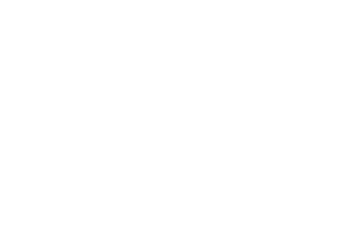

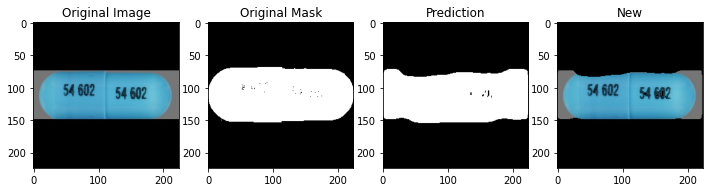

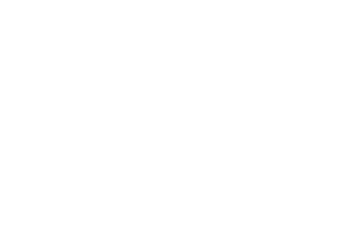

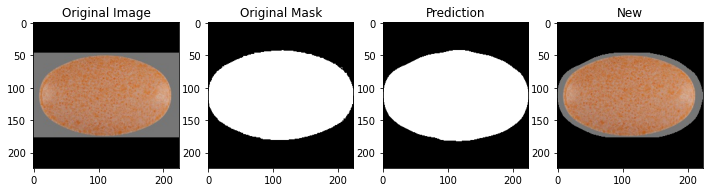

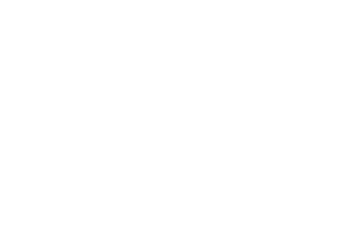

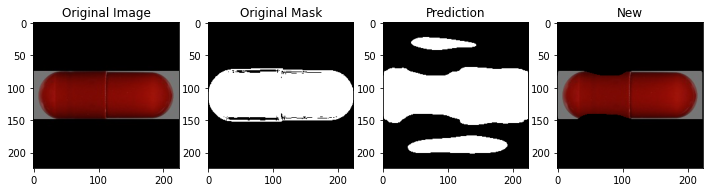

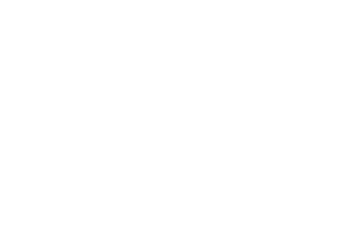

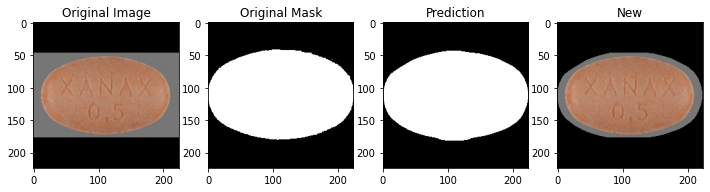

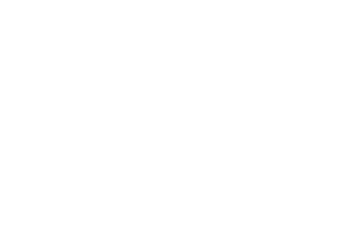

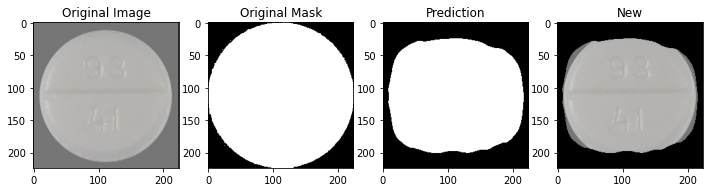

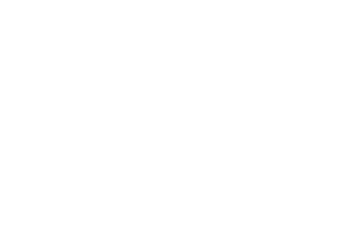

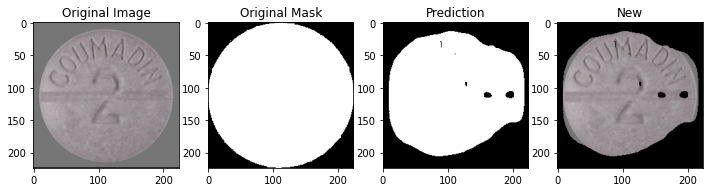

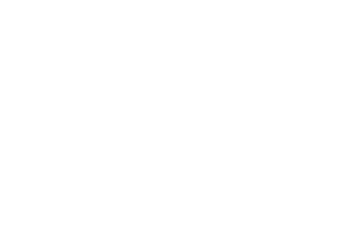

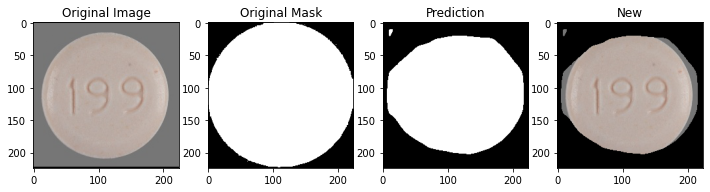

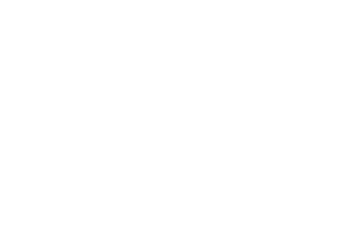

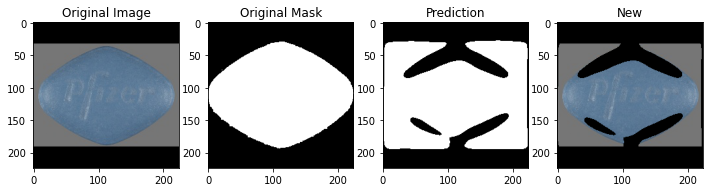

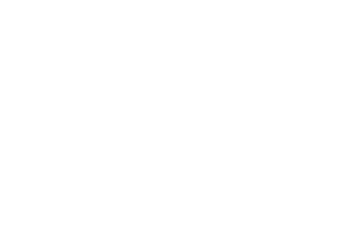

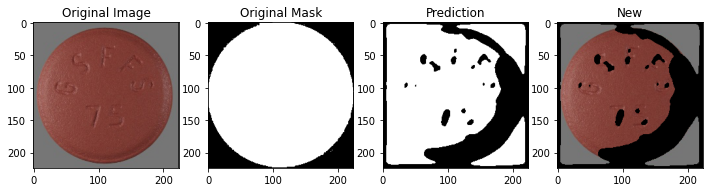

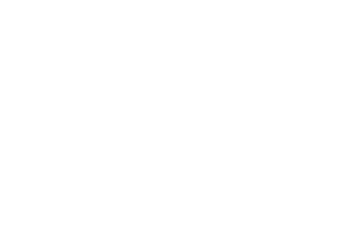

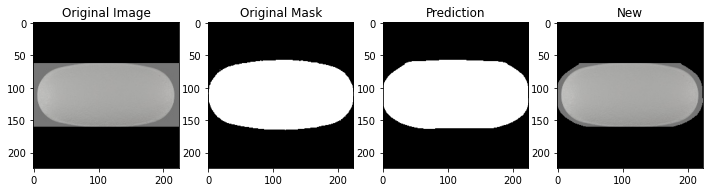

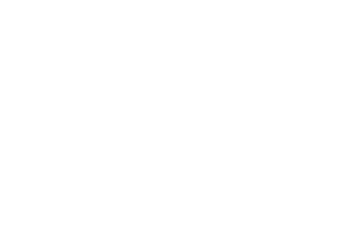

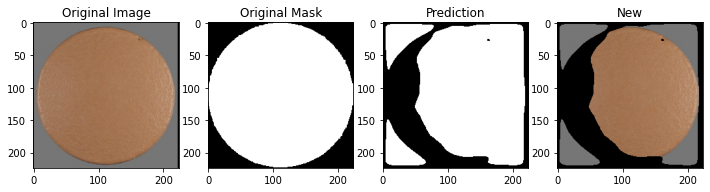

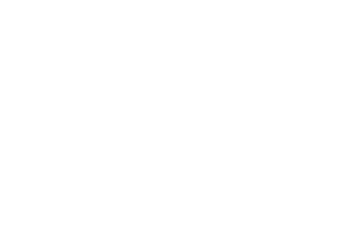

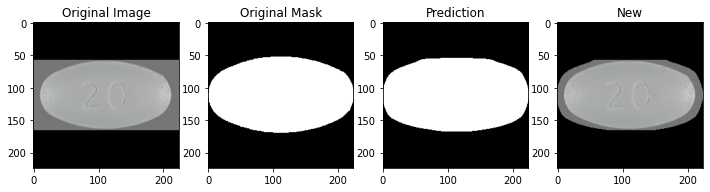

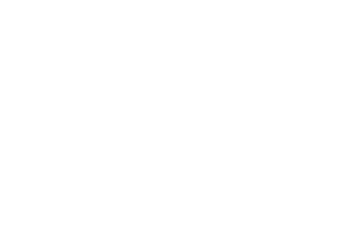

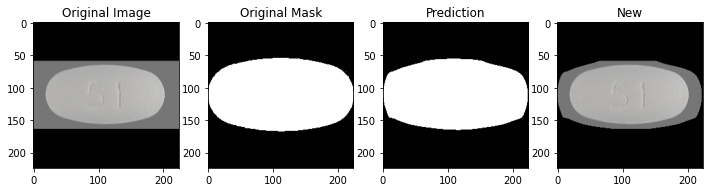

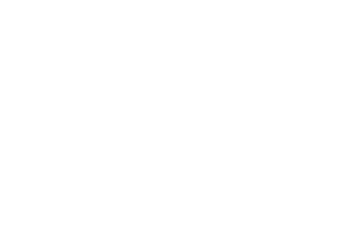

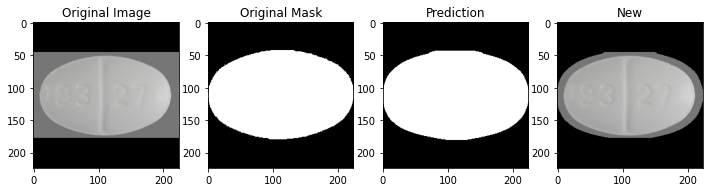

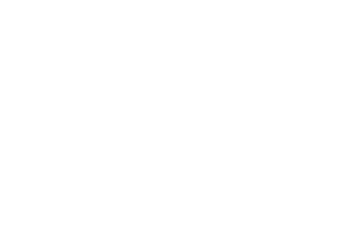

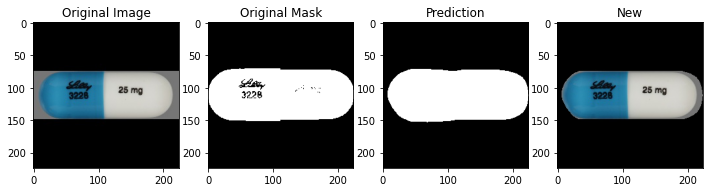

In [63]:
from PIL import Image

for i in range(len(df_test)):
    img = Image.open(df_test['image_path'].iloc[i])
    img = transforms.ToTensor()(img).to(device)
    img = img.reshape(1,3,224,224)
    pred=model(img)
    plt.axis('off')
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img.permute(0,2,3,1).data.cpu().numpy()))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    mask = transforms.ToTensor()(Image.open(df_test['mask_path'].iloc[i]).convert('L'))
    mask[mask>0.1]=1
    mask[mask<=0.1]=0
    plt.imshow(np.squeeze(mask),'gray')
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.array(pred.reshape(224,224).data.cpu().numpy())>=0.5 ,'gray')
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(img.permute(0,2,3,1).data.cpu().numpy())*(np.array(pred.reshape(224,224,1).data.cpu().numpy()) >= .5))
    plt.title('New')
    plt.show()
    #index = index +1